# Low / High Pass filter



In [1]:
from IPython.display import (
    Audio, 
    display
)
import librosa
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

# Data

In [2]:
data, original_sampling_rate = librosa.load("./data/jfk.flac", sr=None)
sampling_rate = original_sampling_rate
# sampling_rate = 8192
# data = librosa.resample(y=data, orig_sr=original_sampling_rate, target_sr=sampling_rate, scale=False)
# data = data * (data > 0.1)
#data, sampling_rate = librosa.load("/home/eml/home/repository/data/ml/LibriSpeechNoiseDataset/train/19-198-0003.wav", sr-None)

N = num_total_samples = data.shape[0]

print(f"sampling_rate:[{sampling_rate}], duration:[{data.shape[0] / sampling_rate}] seconds") 
display(Audio(data=data, rate=sampling_rate))

sampling_rate:[44100], duration:[11.0] seconds


# Sound Wave


# Audio Wave (Time Series)

Amplitude of the signal on the y-axis and time along the x-axis

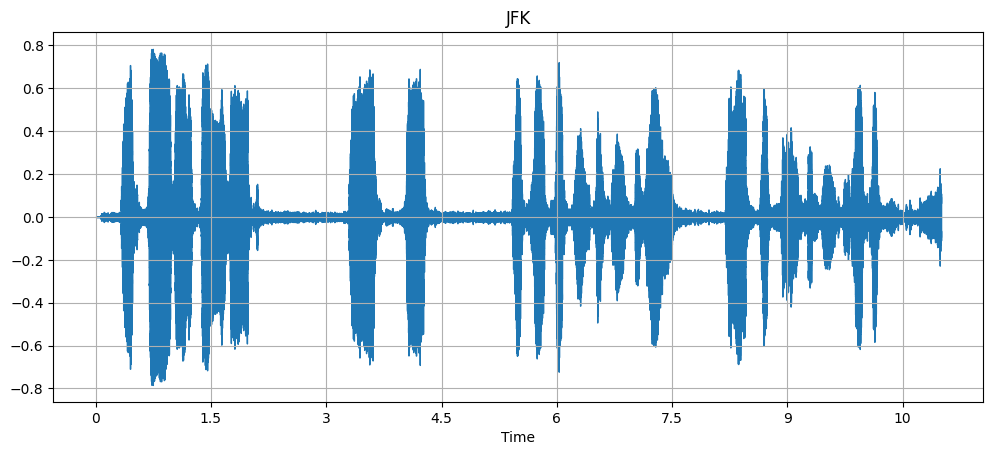

In [3]:
plt.figure().set_figwidth(12)
plt.title("JFK")
plt.grid()
librosa.display.waveshow(y=data, sr=sampling_rate)

# Frequency Spectrum

The frequency values are on the x-axis, usually plotted on a logarithmic scale, while their amplitudes are on the y-axis.

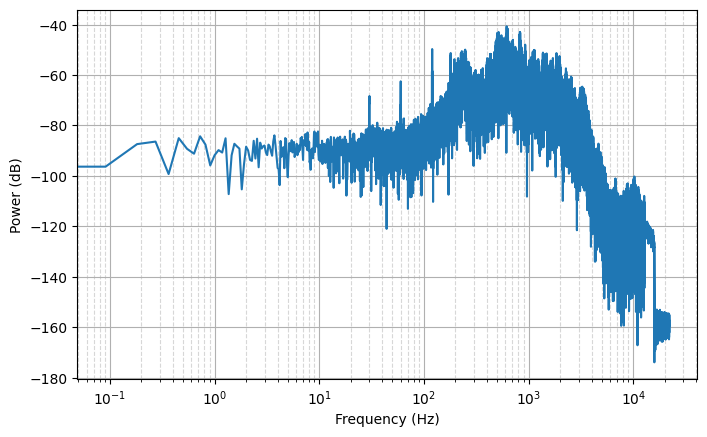

In [4]:
# dft_input = data[:sampling_rate]  # First 1 second
dft = np.fft.rfft(data, norm="forward")
amplitude = 2 * np.abs(dft)
db = 20 * np.log10(amplitude)

# To be compatibe with librosa
# amin=1e-10
# db: np.ndarray = 10.0 * np.log10(np.maximum(amin, amplitude**2))
# db -= 10.0 * np.log10(np.maximum(amin, 1.0))

# get the frequency bins
# frequency = librosa.fft_frequencies(sr=sampling_rate, n_fft=len(dft_input))
frequency = np.fft.rfftfreq(n=len(data), d=1/sampling_rate)

plt.figure().set_figwidth(8)
plt.plot(frequency, db)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (dB)")
plt.grid(visible=True, which='major')
plt.grid(visible=True, which='minor', linestyle='--', alpha=0.5)
plt.xscale("log")

## melspectrogram

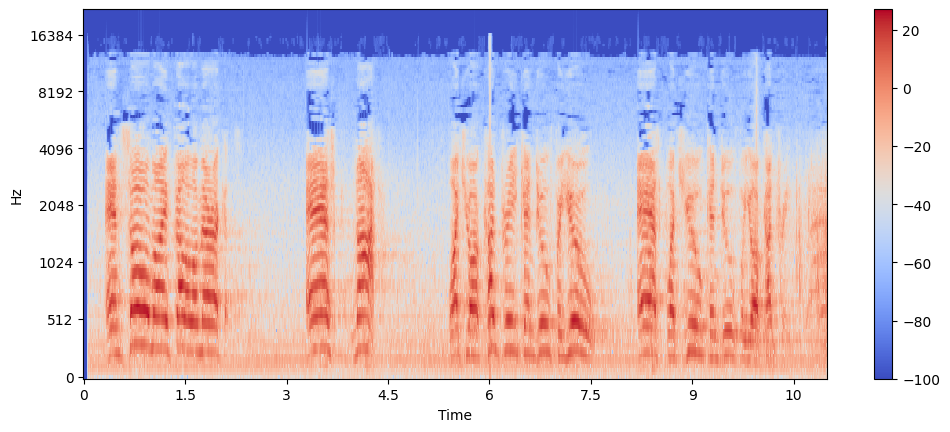

In [5]:
S = librosa.feature.melspectrogram(
    y=data, sr=sampling_rate, n_mels=128, fmax=sampling_rate/2, n_fft=1024, hop_length=512
)
S_dB = librosa.power_to_db(S, ref=1, top_db=None, amin=1e-10)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=sampling_rate, fmax=sampling_rate/2)
plt.colorbar()

# Bandpass Filter

The human voice frequency band ranges from approximately 300 Hz to 3000 Hz.

In [6]:
HIGHCUT = 3000
LOWCUT = 300
ORDER = 10

In [7]:
def butter_bandpass(
    lowcut,
    highcut,
    sampling_rate: int,
    order: int = 5
):
    """
    Args:
        signal: signal data to filter
        lowcut: low cut-off frequency
        highcut: high cut-off frequency
        sampling_rate: sampling rate used to sample the signal
        order: filter order
    Returns: filtered output
    """
    nyquist = 0.5 * sampling_rate
    low = lowcut / nyquist
    high = highcut / nyquist
    sos = sp.signal.butter(N=order, Wn=[low, high], btype='band', analog=False, output='sos')
    return sos


def butter_bandpass_filter(
    signal: np.ndarray,
    lowcut,
    highcut,
    sampling_rate: int,
    order: int = 5
):
    """Butterworth bandpath filter
    Args:
        signal: signal data to filter
        lowcut: low cut-off frequency
        highcut: high cut-off frequency
        sampling_rate: sampling rate used to sample the signal
        order: filter order
    """
    sos = butter_bandpass(
        lowcut=lowcut,
        highcut=highcut,
        sampling_rate=sampling_rate, order=order)
    y = sp.signal.sosfilt(sos=sos, x=signal)
    return y

In [8]:
bandpassed = butter_bandpass_filter(signal=data, lowcut=LOWCUT, highcut=HIGHCUT, sampling_rate=sampling_rate, order=ORDER)

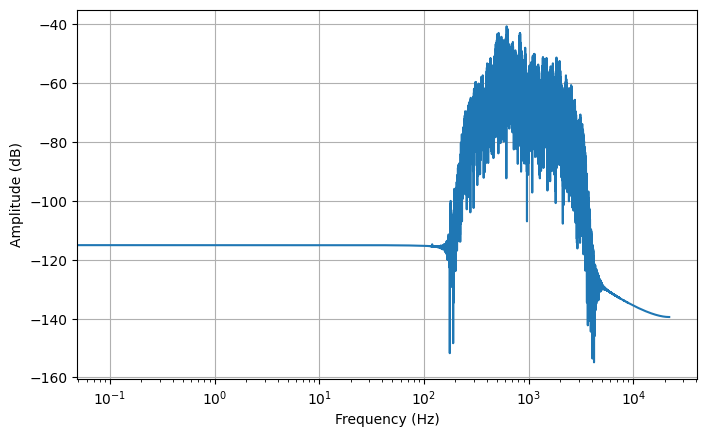

In [9]:
dft_filtered = np.fft.rfft(bandpassed, norm="forward", axis=-1)
amplitude_filtered = 2 * np.abs(dft_filtered)
# amplitude_filtered_db = librosa.amplitude_to_db(amplitude_filtered)
amplitude_filtered_db = 20 * np.log10(amplitude_filtered)

plt.figure().set_figwidth(8)
plt.plot(frequency, amplitude_filtered_db)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.grid()
plt.xscale("log")

In [10]:
display(Audio(data=bandpassed, rate=sampling_rate))

# Filter by power spectrum

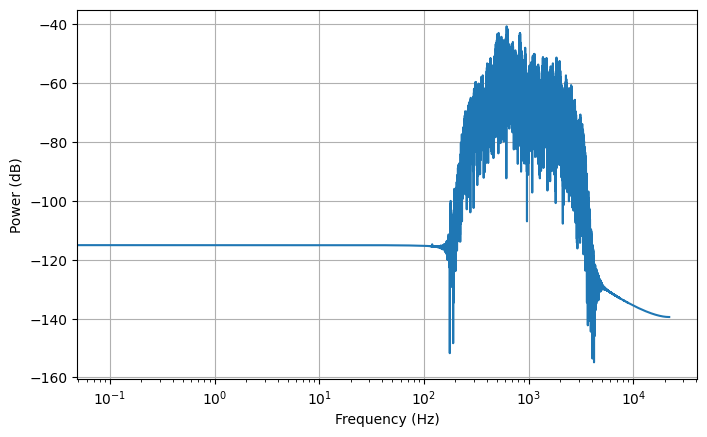

In [11]:
fhat = np.fft.rfft(a=bandpassed, norm="forward", axis=-1)
amplitude = 2 * np.abs(fhat)
# db = librosa.amplitude_to_db(amplitude)
db = 20 * np.log10(amplitude)
plt.figure().set_figwidth(8)
plt.plot(frequency, db)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (dB)")
plt.grid()
plt.xscale("log")

In [12]:
power_filter_indices = db > -90

/tmp/ipykernel_81900/1877303048.py:3: RuntimeWarning: divide by zero encountered in log10
  db_pwer_filtered = 20 * np.log10(2 * np.abs(fhat_power_filtered))


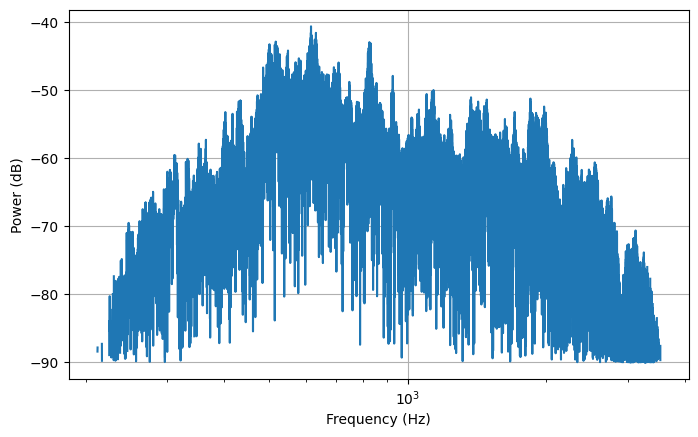

In [13]:
fhat_power_filtered = fhat * power_filter_indices

db_pwer_filtered = 20 * np.log10(2 * np.abs(fhat_power_filtered))

plt.figure().set_figwidth(8)
plt.plot(frequency, db_pwer_filtered)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (dB)")
plt.grid()
plt.xscale("log")

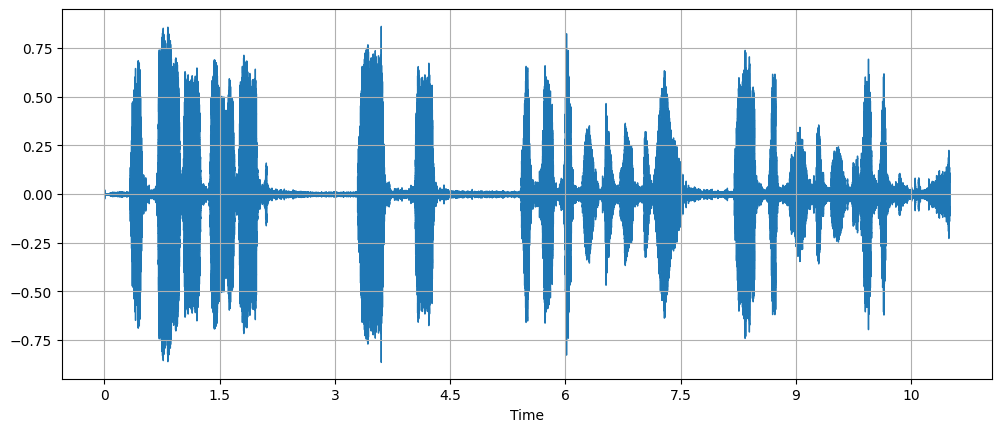

In [14]:
bandpassed_power_filted = np.fft.irfft(fhat_power_filtered, norm="forward")

plt.figure().set_figwidth(12)
plt.grid()
librosa.display.waveshow(y=bandpassed_power_filted, sr=sampling_rate)
display(Audio(data=bandpassed_power_filted, rate=sampling_rate))

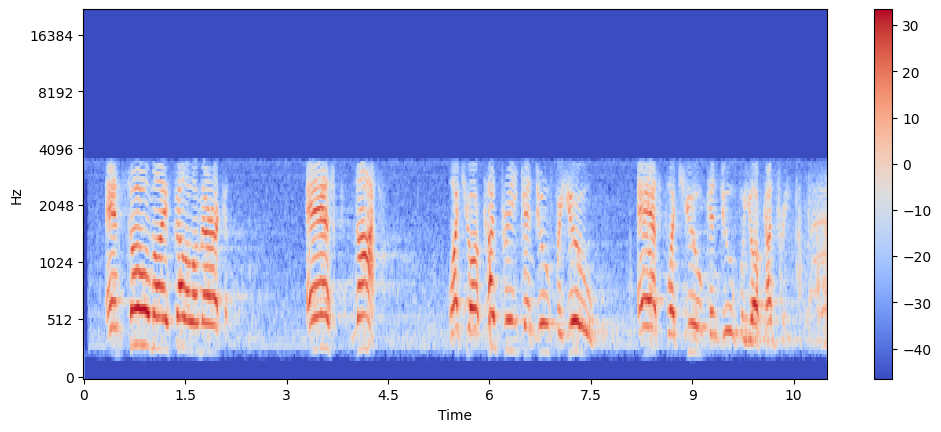

In [15]:
S = librosa.feature.melspectrogram(y=bandpassed_power_filted, sr=sampling_rate, n_mels=128, fmax=sampling_rate/2)
S_dB = librosa.power_to_db(S)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=sampling_rate, fmax=sampling_rate/2)
plt.colorbar()